# AI4M Course 1 week 3 lecture notebook

<a name="data"></a>
# Explore the data

<img src="https://raw.githubusercontent.com/hardik0/AI-for-Medicine-Specialization/master/AI-for-Medical-Diagnosis/Week-3/mri-slice.png" alt="U-net Image" width="300"/>

In this week's assignment, you'll be working with 3D MRI brain scans from the public [Medical Segmentation Decathalon](https://decathlon-10.grand-challenge.org/) challenge project. This is an incredibly rich dataset that provides you with labels associated with each point (voxel) inside a 3D representation of a patient's brain. Ultimately, in this week's assignment, you will train a neural network to make three-dimensional spatial segmentation predictions for common brain disorders.

In this notebook, you're all set up to explore this exciting dataset. Run the code below and tweak it to explore further!

In [1]:
!git clone https://github.com/hardik0/AI-for-Medicine-Specialization
%cd AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis/

fatal: destination path 'AI-for-Medicine-Specialization' already exists and is not an empty directory.
/content/AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis


In [ ]:
!pip install itk itkwidgets ipywidgets

### Import packages
For this lab, you'll import some of the packages you've seen before (`numpy`, `matplotlib` and `seaborn`) as well as some new ones for reading (`nibabel`) and visualizing (`itk`, `itkwidgets`, `ipywidgets`) the data. Run the next cell to import these packages.

In [2]:
# Import all the necessary packages
import numpy as np
import nibabel as nib
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

### Loading Images of the brain
Run the next cell to grab a single 3D MRI brain scan

In [3]:
# Define the image path and load the data
image_path = "BraTS-Data/imagesTr/BRATS_001.nii.gz"
image_obj = nib.load(image_path)
print(f'Type of the image {type(image_obj)}')

Type of the image <class 'nibabel.nifti1.Nifti1Image'>


### Extract the data as a numpy array
Run the next cell to extract the data using the `get_fdata()` method of the image object

In [4]:
# Extract data as numpy ndarray
image_data = image_obj.get_fdata()
type(image_data)

numpy.ndarray

In [5]:
# Get the image shape and print it out
height, width, depth, channels = image_data.shape
print(f"The image object has the following dimensions: height: {height}, width:{width}, depth:{depth}, channels:{channels}")

The image object has the following dimensions: height: 240, width:240, depth:155, channels:4


As you can see these "image objects" are actually 4 dimensional! With the exploratory steps below you'll get a better sense of exactly what each of these dimensions represents.

### Visualize the data
The "depth" listed above indicates that there are 155 layers (slices through the brain) in every image object. To visualize a single layer, run the cell below. Note that if the layer is one of the first or the last (`i` near 0 or 154), you won't find much information and the screen will be dark. Run this cell multiple times to look at different layers.

The code is set up to grab a random layer but you can select a specific layer by choosing a value for `i` from 0 to 154. You can also change which channel you're looking at by changing the `channel` variable.

Keep in mind that you could just as easily look at slices of this image object along the height or width dimensions. If you wish to do so, just shift `i` to a different dimension in the `plt.imshow()` command below. Which slice direction looks the most interesting to you?

Plotting Layer 87 Channel 0 of Image


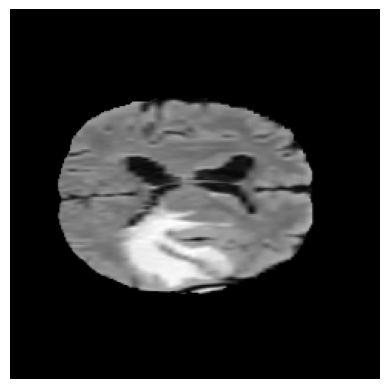

In [6]:
# Select random layer number
maxval = 154
i = np.random.randint(0, maxval)
# Define a channel to look at
channel = 0
print(f"Plotting Layer {i} Channel {channel} of Image")
plt.imshow(image_data[:, :, i, channel], cmap='gray')
plt.axis('off');

### Interactive exploration
Another way to visualize this dataset is by using IPython Widgets to allow for an interactive exploration of the data.

Run the next cell to explore across different layers of the data. Move the slider to explore different layers. Change the `channel` value to explore different channels. See if you can tell which layer corresponds to the top of the brain and which corresponds to the bottom!

If you're feeling ambitious, try modifying the code below to slice along a different axis through the image object and look at other channels to see what you can discover!

In [14]:
def explore_3dimage(layer, axis=2, channel=2):
    """
    Visualize a 3D MRI image by slicing along a specified axis and channel.

    Args:
        layer (int): The slice index along the specified axis.
        axis (int): The axis to slice along (0 for x, 1 for y, 2 for z).
        channel (int): The channel/modality to display (for 4D data).
    """
    plt.figure(figsize=(10, 5))

    # Ensure image_data is defined and has the expected shape
    if not isinstance(image_data, np.ndarray) or len(image_data.shape) != 4:
        raise ValueError("image_data must be a 4D NumPy array (height, width, depth, channels)")

    height, width, depth, num_channels = image_data.shape

    # Validate inputs
    if axis not in [0, 1, 2]:
        raise ValueError("Axis must be 0 (x), 1 (y), or 2 (z)")
    if channel >= num_channels:
        raise ValueError(f"Channel must be between 0 and {num_channels - 1}")

    # Select slice based on axis
    if axis == 0:  # Slice along x-axis (height)
        slice_data = image_data[layer, :, :, channel]
        title = f'X-axis Slice {layer} (Channel {channel})'
    elif axis == 1:  # Slice along y-axis (width)
        slice_data = image_data[:, layer, :, channel]
        title = f'Y-axis Slice {layer} (Channel {channel})'
    else:  # Slice along z-axis (depth)
        slice_data = image_data[:, :, layer, channel]
        title = f'Z-axis Slice {layer} (Channel {channel})'

    # Display the slice
    plt.imshow(slice_data, cmap='gray')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

    return layer

In [15]:
def interactive_3dimage_explorer(image_data):
    """
    Create an interactive widget to explore 3D image data along different axes and channels.

    Args:
        image_data (np.ndarray): 4D array of shape (height, width, depth, channels)
    """
    height, width, depth, num_channels = image_data.shape

    interact(
        explore_3dimage,
        layer=(0, [height, width, depth][2] - 1),  # Default to z-axis max
        axis={'X (height)': 0, 'Y (width)': 1, 'Z (depth)': 2},
        channel=(0, num_channels - 1)
    )

In [16]:
interactive_3dimage_explorer(image_data)

interactive(children=(IntSlider(value=77, description='layer', max=154), Dropdown(description='axis', index=2,…

### Explore the data labels
In this section, you'll read in a new dataset containing the labels for the MRI scan you loaded above.

Run the cell below to load the labels dataset for the image object you inspected above.

In [8]:
# Define the data path and load the data
label_path = "./BraTS-Data/labelsTr/BRATS_001.nii.gz"
label_obj = nib.load(label_path)
type(label_obj)

nibabel.nifti1.Nifti1Image

### Extract the data as a numpy array
Run the next cell to extract the data labels using the `get_fdata()` method of the image object

In [9]:
# Extract data labels
label_array = label_obj.get_fdata()
type(label_array)

numpy.ndarray

In [10]:
# Extract and print out the shape of the labels data
height, width, depth = label_array.shape
print(f"Dimensions of labels data array height: {height}, width: {width}, depth: {depth}")
print(f'With the unique values: {np.unique(label_array)}')
print("""Corresponding to the following label categories:
0: for normal
1: for edema
2: for non-enhancing tumor
3: for enhancing tumor""")


Dimensions of labels data array height: 240, width: 240, depth: 155
With the unique values: [0. 1. 2. 3.]
Corresponding to the following label categories: 
0: for normal 
1: for edema
2: for non-enhancing tumor 
3: for enhancing tumor


### Visualize the labels for a specific layer
Run the next cell to visualize a single layer of the labeled data. The code below is set up to show a single layer and you can set `i` to any value from 0 to 154 to look at a different layer.

Note that if you choose a layer near 0 or 154 there might not be much to look at in the images.

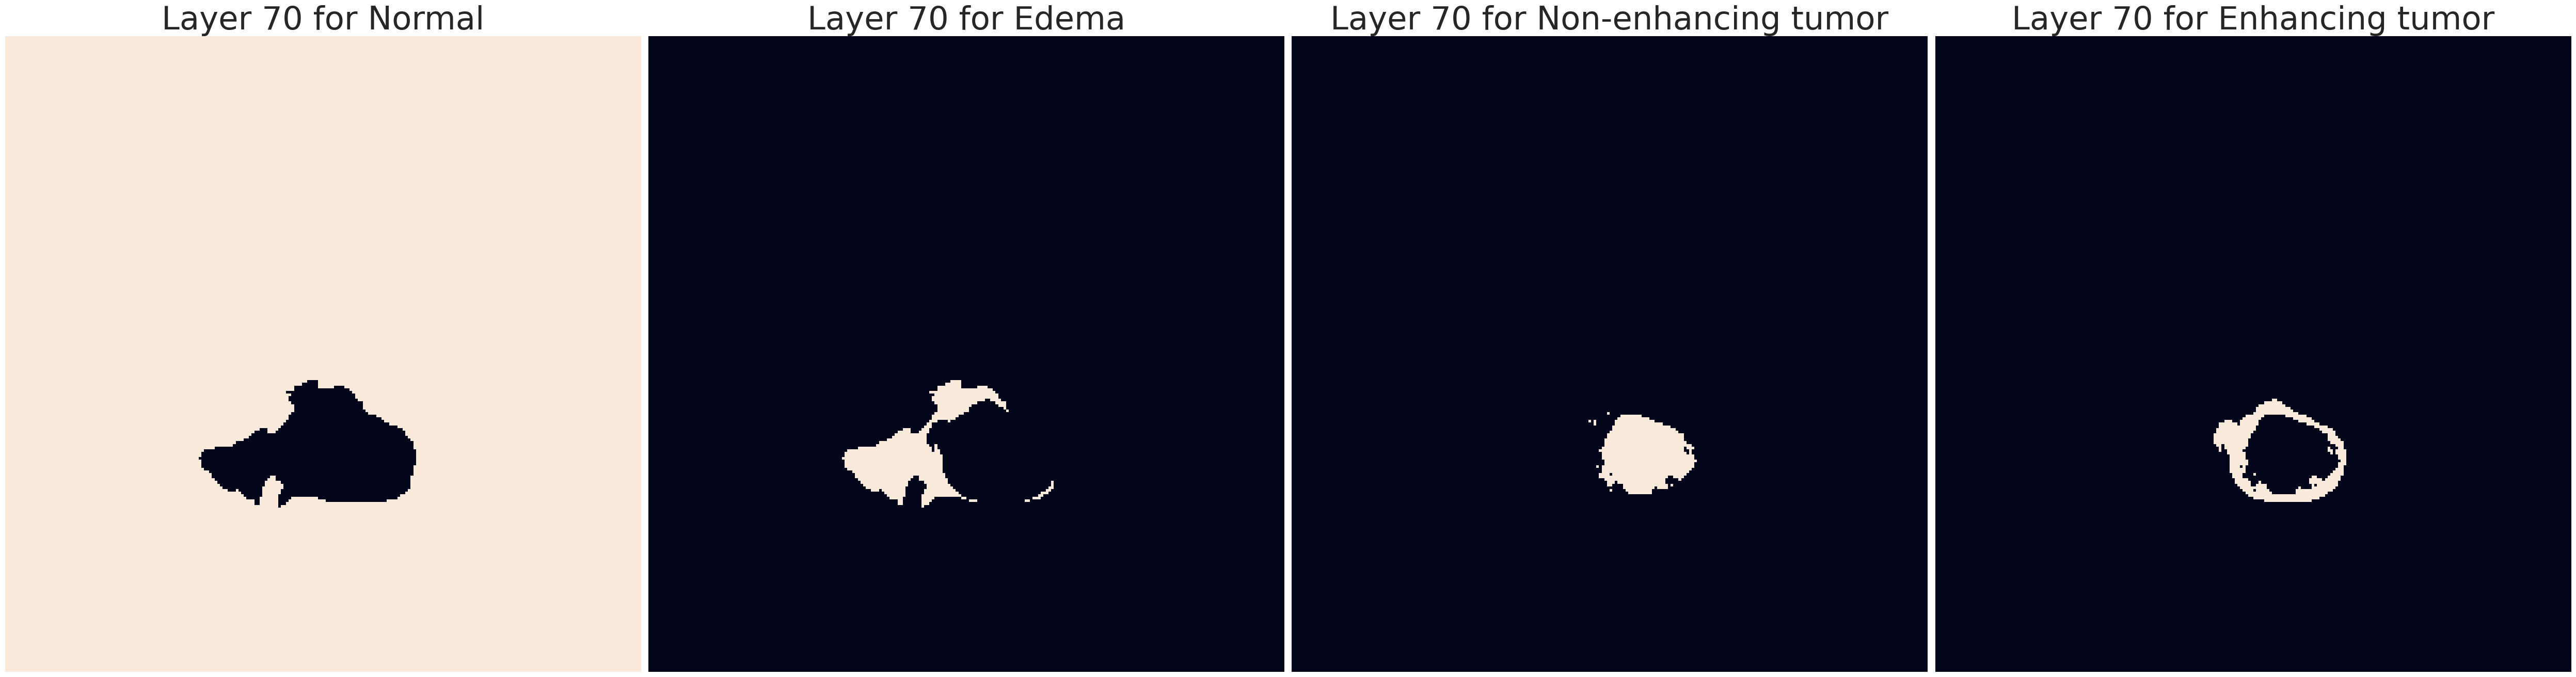

In [11]:
# Define a single layer for plotting
layer = 70
# Define a dictionary of class labels
classes_dict = {
    'Normal': 0.,
    'Edema': 1.,
    'Non-enhancing tumor': 2.,
    'Enhancing tumor': 3.
}
# Set up for plotting
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(50, 30))
for i in range(4):
    img_label_str = list(classes_dict.keys())[i]
    img = label_array[:,:,layer]
    mask = np.where(img == classes_dict[img_label_str], 255, 0)
    ax[i].imshow(mask)
    ax[i].set_title(f"Layer {layer} for {img_label_str}", fontsize=45)
    ax[i].axis('off')
plt.tight_layout()

### Interactive visualization across layers
As another way of looking at the data, run the code below to create a visualization where you can choose the class you want to look at by clicking a button to choose a particular label and scrolling across layers using the slider!

In [37]:
# Create button values
select_class = ToggleButtons(
    options=['Normal','Edema', 'Non-enhancing tumor', 'Enhancing tumor'],
    description='Select Class:',
    disabled=False,
    button_style='info',

)
# Create layer slider
select_layer = IntSlider(min=0, max=154, description='Select Layer', continuous_update=False)


# Define a function for plotting images
def plot_image(seg_class, layer):
    print(f"Plotting {layer} Layer Label: {seg_class}")
    img_label = classes_dict[seg_class]
    mask = np.where(label_array[:,:,layer] == img_label, 255, 0)
    plt.figure(figsize=(10,5))
    plt.imshow(mask, cmap='gray')
    plt.axis('off');

# Use the interactive() tool to create the visualization
interactive(plot_image, seg_class=select_class, layer=select_layer)

interactive(children=(ToggleButtons(button_style='info', description='Select Class:', options=('Normal', 'Edem…

#### And there you have it! We hope this lab has helped you get a better sense of the data you'll be working with in this week's assignment.